In [1]:
# Information on autoreload: https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


In [3]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2
import scipy
import scipy.misc
from matplotlib import gridspec
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
import skimage

import os

In [4]:
import src.synthetic_aperture as synthetic_aperture
import src.code as code
import src.util_synthetic as util_synthetic

# <span style="color:orange">Part 2: Approximating a light-field with a Smartphone Camera</span>

In the second part of the homework, you will capture a light field by waving your smartphone/tablet camera around. The goal of is to synthesize an image that appears to be captured with an aperture that is much larger than your smartphone/tablet camera's aperture [1]. 

The **advantage** of this technique is that captured images will appear to have a significantly smaller depth of field, giving the look and feel of a much more expensive camera. The other advantage is that, because we are capturing a light field, we can digitally refocus the image to any location we desire.

The **disadvantage** of this technique is that, because it relies on a sequential image capture, it will only work for static scenes. The technique requires the image sequence to be registered, and the quality of the final photograph will be limited by how well the images can be registered. In this homework, we will use a simple correlation (or template-matching) based registration scheme.

Reference:

[1] Synthetic aperture confocal imaging, Marc Levoy, Billy Chen, Vaibhav Vaish, Mark Horowitz, Ian McDowall, and Mark Bolas. 2004. ACM Trans. Graph. 23, 3 (August 2004), 825-834. 

![test](pictures/camera-motion.png)

**Figure 1:** Capture an unstructured light field of a scene by waving a camera in front of a scene. Make sure the motion is in a plane.

![test](pictures/dataset_sample.png)

**Figure 2:** Four images from a video captured using the zig-zag motion shown in Figure 1. The red box shows the template that is used to register the video frames in the next part 2 of this homework.

For implementing and debugging your algorithm we are providing you with a sample movie dataset, so that you can be sure that the data is good enough for the algorithm to work. Your own data might be not ideal (in case you do something wrong) and it might not be working because of the data you have acquired.

First you will load the video data into a large numpy array. Then you'll have to register each frame of the captured video using a correlation function and generate synthetic aperture photos.

Registration can be performed on either grayscale video frames or color images. You will use a simple template-matching scheme as described in the first lecture on image processing, but fortunately you don't have to implement this because there are many packages that do this for you.

Here are more datailed instructions on what you need to do:

1.    Use the **DATALOADER:**: We wrote a program to load the video into an n-darray from an .mp4 file
2.    You can use all of the frames in the video, but this may make your processing slow if you captured more than a few seconds of video. You should be able to get away with selecting about 50 to 60 frames for processing (for instance by selecting only every few frames).
3.    The red box in Figure 2 shows the template that was used for registration. You will need to select a similar template from the first frame of your video. You will then search for a match to this template in successive frames. The location of the match will tell you how many pixels your camera has shifted. Choose a size for this template (i.e. 16x16 pixels). You may need to adjust this to improve your results.
4.    You only need to search for a template match within a window of your target frame. The window should be centered on the location of the template in the first frame. The size of the window should be slightly larger than the sum of the template size and the maximum shift of the target object over the entire set of video frames.

## <span style="color:orange">Task 1: Load the the data</span>

In [5]:
# After the implementation for this dataset you want to replace this with your own movie file
# For now you can keep it though
path = 'data_part2/example_synthetic_aperture.MOV'

In [6]:
# We're implementing this for you for the .mov file datatype. 
# It might work for you movie files out-of-the-box. But must likely you'll
# need to adapt this slightly

imgs = util_synthetic.read_video_to_array(path)

imgs = imgs[:,:,:,::10] # only take every 10th frame

print(imgs.shape) # Should be (Num_x, Num_y, 3, Num_images)

(272, 480, 3, 51)


Text(0.5, 1.0, 'An example image from the dataset')

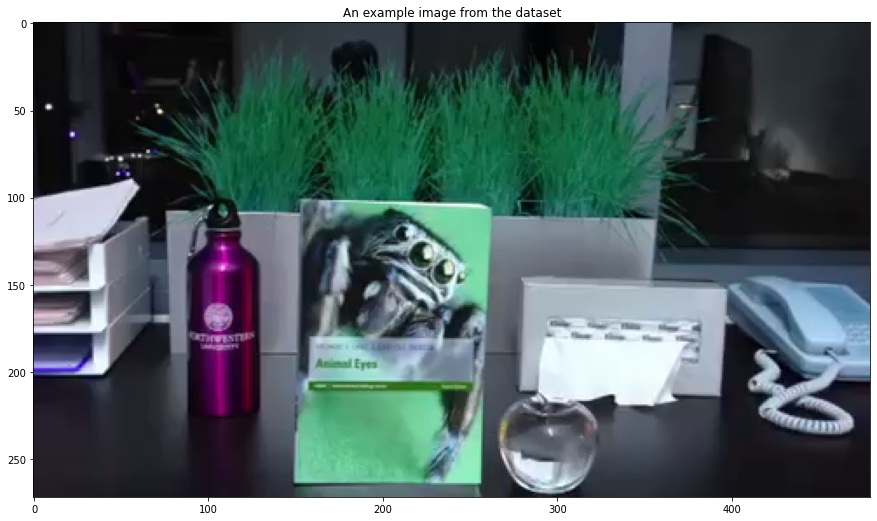

In [7]:
plt.figure(figsize=(15,15))
plt.imshow(imgs[:,:,:,0]) # You might want to play around with this index to see that different images can be loaded correctly
plt.title("An example image from the dataset")

## <span style="color:orange">Task 2: Crop the windows and template</span>

In [8]:
#
# Now you will have to implement a function that crops the search window and the template out of the video data
# You will return the cropped window for each frame and the template from to initial frame (the first one)
#

window_size = 150 # The size of the window. You can vary this if wanted.
template_size = 30 # The template size. This parameter might need to be varied to work well

focus_center = (120,210)

window, template, top_left_search_window, top_left_template= synthetic_aperture.crop_search_window(imgs,window_size,template_size,focus_center)


print(window.shape) # Should be (window_size,window_size,3,num_mgs)
print(template.shape) # Should be (template_size, template_size, 3)

print("Top-Left Corner of Search Window")
print(top_left_search_window) # 1D array with 2 entries for x and y
print("Top-Left Corner of Template Window")
print(top_left_template) # 1D array with 2 entries for x and y

(150, 150, 3, 51)
(30, 30, 3)
Top-Left Corner of Search Window
(45, 135)
Top-Left Corner of Template Window
(105, 195)


### <span style="color:orange">Subtask: Visualize what you've done !!! </span>

We have implemented a visualization function for you to sanity check if your cropping actually works.

Feel free to make any changes to this plotting function as you like. If you want to visualize something different please do!

.//output_synthethic//image_window_and_template.png


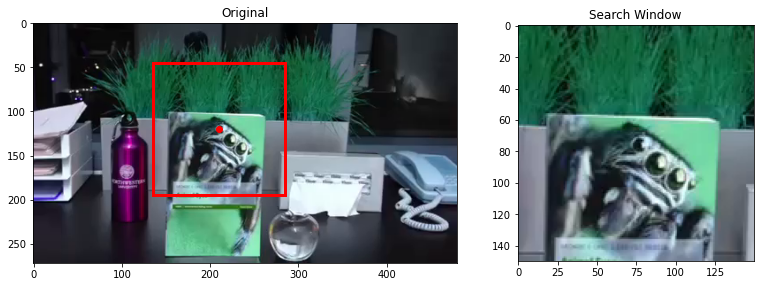

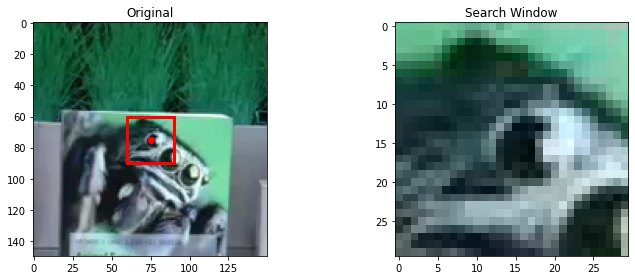

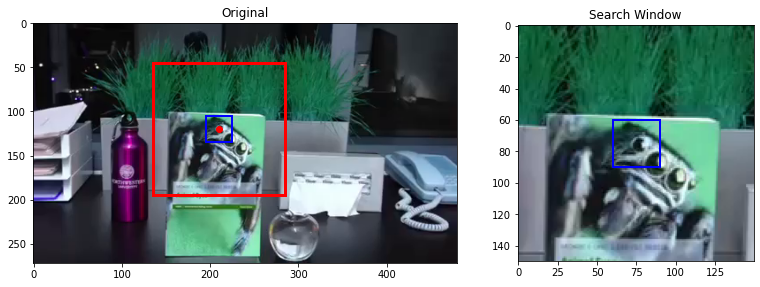

In [9]:
# This function also has the optional argument of plotting the used template
plt.figure(figsize=(11,4))
util_synthetic.plot_image_with_crop(imgs[:,:,:,0],window[:,:,:,0],top_left_search_window)

# This function also has the optional argument of plotting the used template
plt.figure(figsize=(11,4))
util_synthetic.plot_image_with_crop(window[:,:,:,0],template[:,:,:])

# This function also has the optional argument of plotting the used template at the same time if you pass at is an argument
plt.figure(figsize=(11,4))
util_synthetic.plot_image_with_crop(imgs[:,:,:,0],window[:,:,:,0],top_left_search_window,template,top_left_template)

util_synthetic.save_fig_as_png("image_window_and_template")

### <span style="color:orange">Subtask: Visualize the captured lightfield</span>

Visualize the search-window throughout the complete video data. You'll see how the camera has moved. This should remind you a lot to part1 of this homework. However, now we don't know the exact position where we've moved the camera too. This will be subject of this homework to figure out.

.//output_synthethic//visualize_pixelshift.png


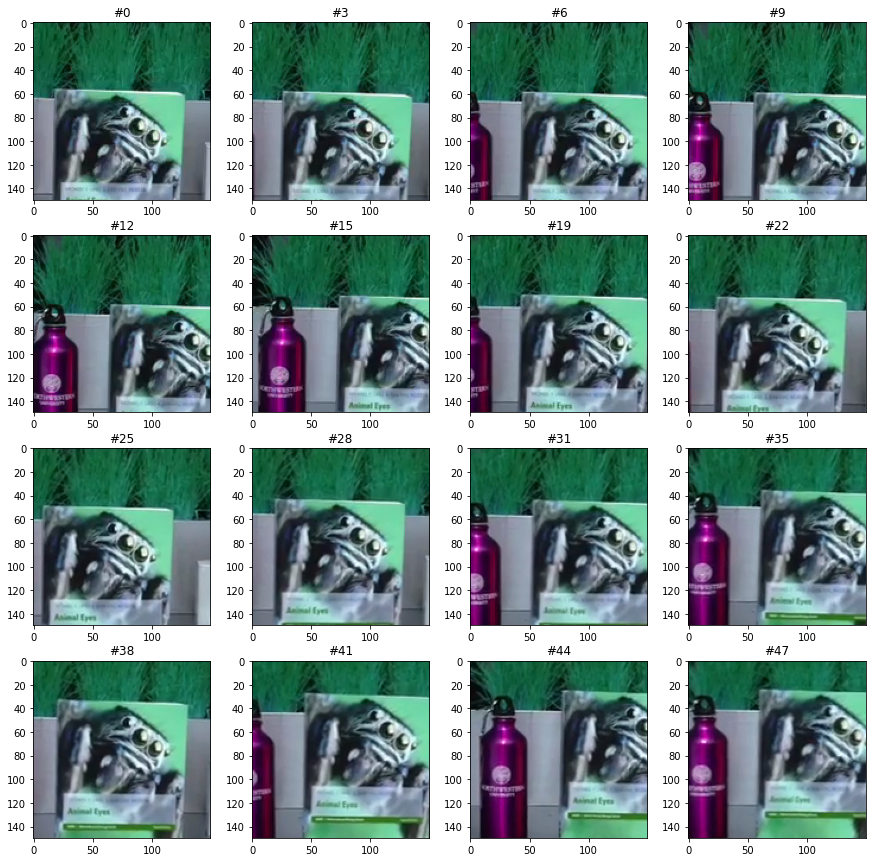

In [10]:
plt.figure(figsize=(15,15))
util_synthetic.visualizePixelShift(window)

util_synthetic.save_fig_as_png("visualize_pixelshift")

## <span style="color:orange">Task 3: Template matching</span>

![test](pictures/search_window.png)

Example how the windows search field and the template should look like.

![test](pictures/pixelshift_pattern.png)

**Figure 4:** The pixel shifts for the video in Figure 1 found from Equation 4.

## <span style="color:orange">MATH: Some math to understand what is going on</span>

Now, we will have to perform an autocorrelation of the template with the extracted search window. If your template $t[n,m]$ is $T \times T$ pixels and your window $w[n,m]$ is $W \times W $ pixels, you will compute the normalized correlation function $\Delta[i,j]$ using the equation:

<h1>$$
\Lambda[i, j]=\frac{1}{N \cdot P} \sum_{n=1}^{T} \sum_{i=1}^{T} t[n, m] \cdot w_{i j}[n, m]
$$<\h1>

where $w_{ij}$ is a block of pixels taken from the window $w$ that is centered on the pixel location $(i,j)$

<h1>
$$
w_{i j}[n, m]=w^{2}\left[n+i-\frac{W}{2}, m+j-\frac{W}{2}\right]
$$ 
<\h1>

and the normalization factors are computed as

<h1>
$$
N=\sum_{n=1}^{T} \sum_{m=1}^{T} t^{2}[n, m]
$$
<br>
$$
P=\sum_{n=1}^{T} \sum_{m=1}^{T} w_{i j}^{2}[n, m]
$$
<\h1>

Note that the normalized factor P is computed over a window the size of the template ( pixels) not over the entire window ( pixels)!

EXTRA POINTS: If you want you can implement this correlation function by yourself. It is very instructive and actually very helpful for understanding this homework. If you want to do this, you can use the numpy function conv to do the sliding window operation of Equation the equation above.

However: In order to save time you can simply use many of the pre-implemented correlation functions available in several Python packages, such as openCV. We will guide you through this later.

Once you have calculated the correlation functions, you will find the pixel shift $[s_x,s_y]$ for each frame of video through following computation as:

<h1>
$$
\left[s_{x}, s_{y}\right]=\underset{i, j}{\operatorname{argmax}} \Delta [i, j](4)
$$
<\h1>
 

### <span style="color:orange">Subtask (a): Template matching</span>

We recommend using openCV's template matching function to do time-efficient matching.

You can read more on this here:

https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_template_matching/py_template_matching.html


In [11]:
# These are the methods of finding correlation between the template and a part of the frame 

methods = ['cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR',
            'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']

# We will be using "cv2.TM_CCOEFF_NORMED" since this works reasonable well. But you're free to use different versions of this!
method = methods[1] 
print(method)

cv2.TM_CCOEFF_NORMED


In [12]:
# Let's correlate the template with the original. You will have to implement this function
print(window[:,:,:,0].shape)
print(template.shape)
res,top_left_correlation = synthetic_aperture.findCorrelation(window[:,:,:,0],template,method)

(150, 150, 3)
(30, 30, 3)


(60, 60)
(121, 121)
.//output_synthethic//image_correlation.png


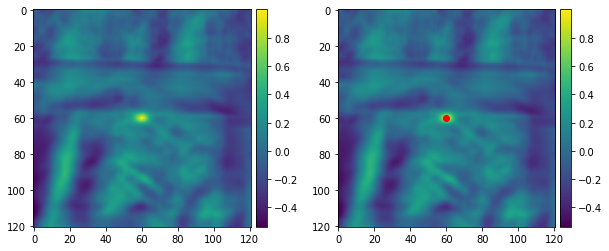

In [13]:
# Let's visualize the output. We've already implemented this for you, so this should work just by executing this cell

print(top_left_correlation)
print(res.shape) 

plt.figure(figsize=(10,4))

plt.subplot(121)
im = plt.imshow(res)
code.add_colorbar(im)

plt.subplot(122)
im = plt.imshow(res)
code.add_colorbar(im)
plt.scatter(top_left_correlation[0],top_left_correlation[1],color='r')

util_synthetic.save_fig_as_png("image_correlation")

### <span style="color:orange">Subtask (b): Template matching of a different image</span>

(58, 113)
.//output_synthethic//image_correlation_different_frame.png


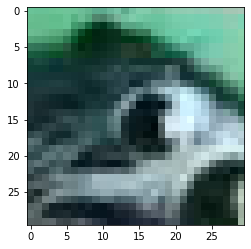

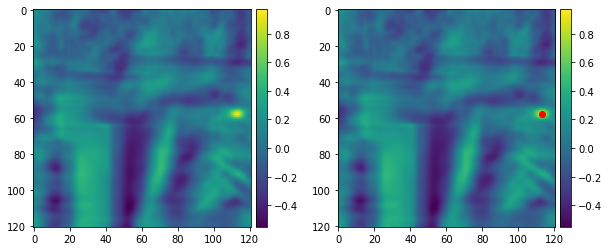

In [14]:
# Let's correlate the template with a different frame !

img_idx = 14
res,top_left_correlation = synthetic_aperture.findCorrelation(window[:,:,:,img_idx],template)
print(top_left_correlation)
plt.imshow(template)


# When we visualize this, you'll hopefully realize that the correlation maximum-spot has now slightly moved to a different positions!
plt.figure(figsize=(10,4))

plt.subplot(121)
im = plt.imshow(res)
code.add_colorbar(im)

plt.subplot(122)
im = plt.imshow(res)
code.add_colorbar(im)
plt.scatter(top_left_correlation[1],top_left_correlation[0],color='r')

util_synthetic.save_fig_as_png("image_correlation_different_frame")

## <span style="color:orange">TASK: Correlate all images</span>

Now you have to implement a function that is correlating all images in your video. Simply loop through all frames and apply the findCorrelation function that you've implemented above.

In [46]:
correlated, top_left_correlated_list = synthetic_aperture.findCorrelationAll(window,template,method)

print(correlated.shape) # Should be (Num_imgs,W-w+1,W-w+1) with W window size and w template size
print(type(top_left_correlated_list)) # Should be a ndarrau
print(top_left_correlated_list.shape) # should be 2 x Num_imgs
print(top_left_correlated_list.dtype) # should be integer

(51, 121, 121)
<class 'numpy.ndarray'>
(2, 51)
int64


## <span style="color:orange">TASK: Visualize the correlation</span>

.//output_synthethic//correlation_all_frames.png


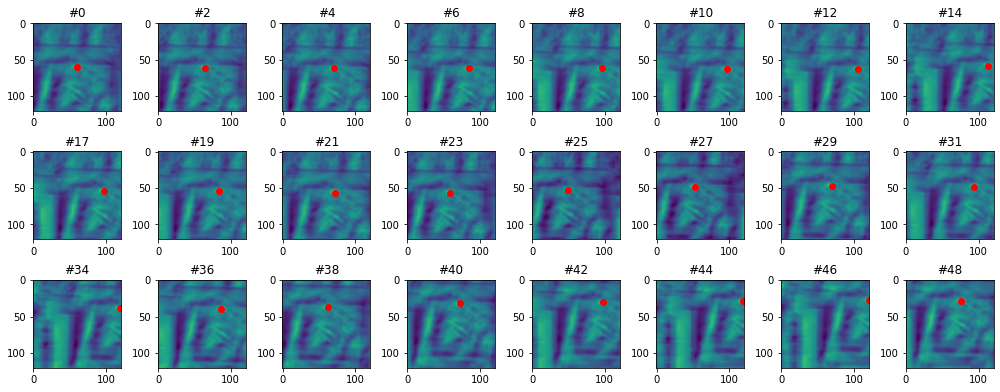

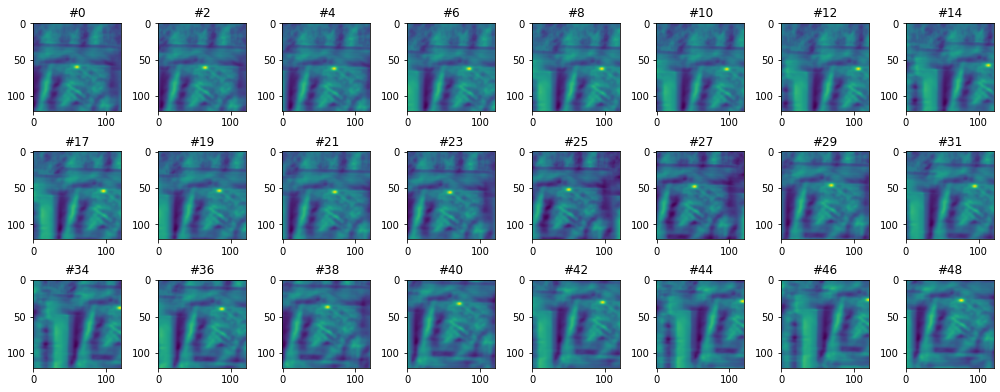

In [47]:
# Make sure that the maximum spot (the red one) overlays with the visible maximum in the correlation images

# Plot with maximum point denoted
plt.figure(figsize = (14,5.5))
util_synthetic.visualize_correlation_output(correlated,top_left_correlated_list,True)

# plot without the maximal point shown to verify that there is actually an minimum
plt.figure(figsize = (14,5.5))
util_synthetic.visualize_correlation_output(correlated,top_left_correlated_list,False)

util_synthetic.save_fig_as_png("correlation_all_frames")

## <span style="color:orange">TASK: Correct pixel locations of correlation output</span>

Now we will have to add the template size to pixel_shifts that you have just calculated to get the coordinates in the original image coordinates!

WHY: Have a look at the output image of the correlated images. This is specific to the correlation function as implemented in openCV.

See documentation here: https://docs.opencv.org/master/d4/dc6/tutorial_py_template_matching.html

HINT: If input image is of size (WxH) and template image is of size (wxh), output image will have a size of (W-w+1, H-h+1). Once you got the result, you can use cv.minMaxLoc() function to find where is the maximum/minimum value. Take it as the top-left corner of rectangle and take (w,h) as width and height of the rectangle. That rectangle is your region of template.

In [48]:
# You need to implement this function
top_left_correlated = synthetic_aperture.correct_correlation_result_to_image_coordinates(top_left_correlated_list,imgs,window,template)

print(top_left_correlated.dtype) # Should be int

int64


#### <span style="color:orange">Subtask: Visualize the new pixel locations</span>

You can use the function "display_new_image_location" and "display_new_image_location_all" which we've already implemented for you to see if everything works as it is supposed to be

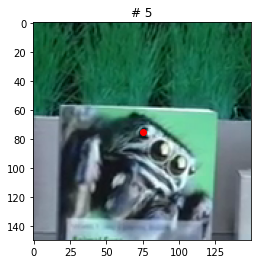

In [49]:
util_synthetic.display_new_image_location(imgs,top_left_correlated,top_left_search_window,window_size,5,False)

Executing the following cell (display_new_image_location_all( will show you an overview of the frames and will also display a red rectangle indicated where the match of the correlation function was found.

It should always show the same part of the image, however at different locations. If this is not the case, go back and try to debug where your problem might occur.

.//output_synthethic//display_new_image_location.png


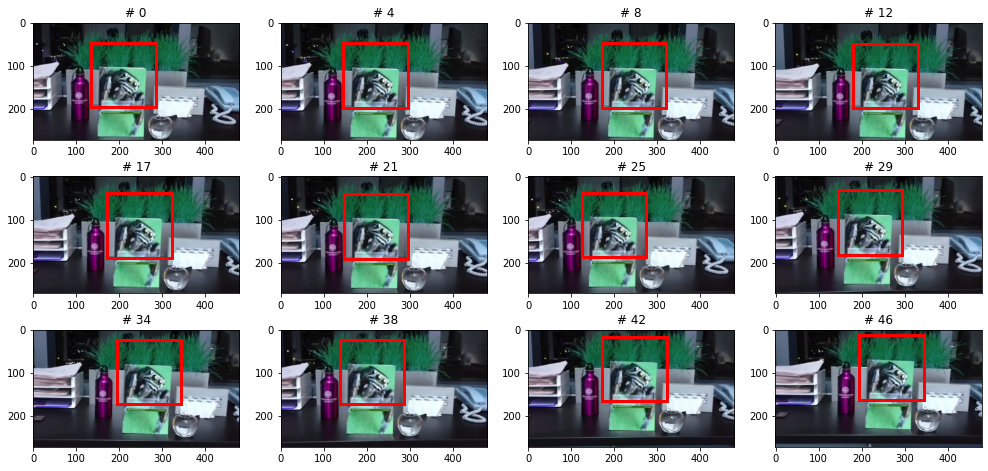

In [50]:
plt.figure(figsize=(17,8))
util_synthetic.display_new_image_location_all(imgs,top_left_correlated,top_left_search_window,window_size)

util_synthetic.save_fig_as_png("display_new_image_location")

#### <span style="color:orange">Subtask: Analze the quality of registration</span>

When you execute the following cell, you will see the registered cropped image of the search window that you have chosen. These should look the same! But watch out carefully. They are only registered, however they are actually not the same because they are captured from different view positions.

The red mark denotes the center of the image. This should be the same feature in all those images since that's where the maximum peak in the correlation algorihtm has been identified. If the center of those images is not the feature that you have chosen, something went wrong you you should go back to your implementation and try to debug.

**Question for you:** Can you spot where other features in the search-window are not the same ?! This indicates that this is actually an approximation of a lightfield, similair to Part 1 of the homework.

.//output_synthethic//display_new_location_cropped.png


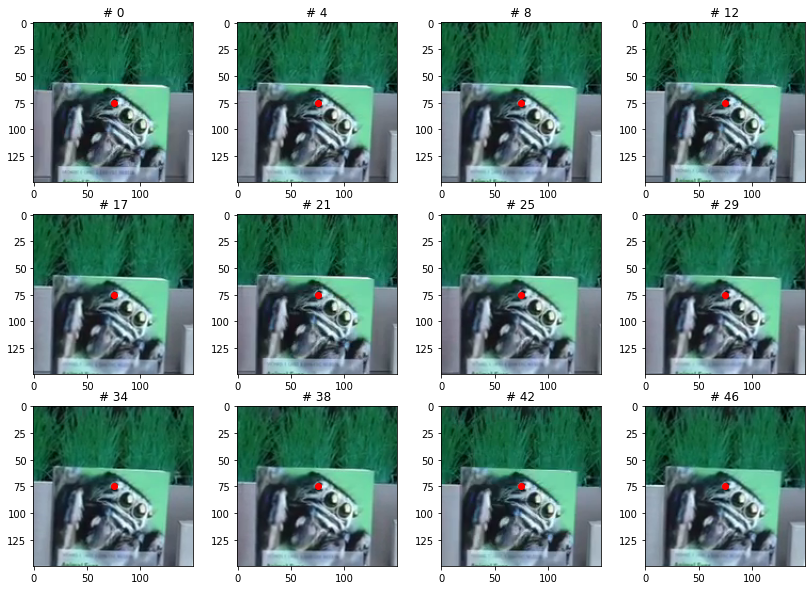

In [51]:
plt.figure(figsize=(14,10))
util_synthetic.display_new_image_location_all(imgs,top_left_correlated,top_left_search_window,window_size,display_full=False)

util_synthetic.save_fig_as_png("display_new_location_cropped")

## <span style="color:orange">Subtask: Visualize Pixel Shift Positions</span>

Instead of visualizing pictures, we're now visualizing the shift positions in a plot. We should then see the trajectory of the smartphone. This should be an almost zig-zag curve which approximately covers a 2D grid, similar to the lightfield capture from Part 1.

In [52]:
pixel_shifts = synthetic_aperture.calculate_pixel_shifts(top_left_correlated)

.//output_synthethic//pixel_shifts_zig_zag.png


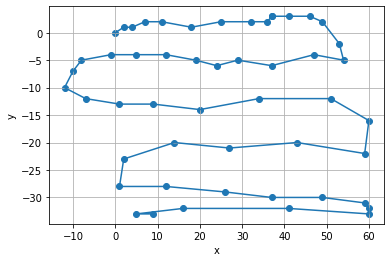

In [53]:
plt.scatter(pixel_shifts[1],pixel_shifts[0])
plt.plot(pixel_shifts[1],pixel_shifts[0])

plt.xlabel("x")
plt.ylabel("y")
plt.grid()

util_synthetic.save_fig_as_png("pixel_shifts_zig_zag")

# <span style="color:orange">Problem 2: Refocus the images</span>

This problem will now focus on refocusing your captured lightfield to any position in the image.

Once you have calculated the pixel shift, you can generate a synthetic aperture photograph simply by shifting the images of each frame of video in the opposite direction and then summing up the result. **Think about why it has to be shifted in negative way**

If the $f_i$ is the ith video frame, and $s_x^i$ and $ s_y^i$ is the shift for that frame, you can simply calculate your synthetic aperture photograph as follows:

<h1>
$$
P[n, m]=\sum_{i=1}^{N} f_{i}\left[n-s_{x}^{i}, m-s_{y}^{i}\right]
$$
<\h1>

**Question for you:** Can you see the resemblance to the refocusing equation in Part 1 of the homework? This is actually quite similar!

Here are 2 example images that focus on the eye of the spider and on the northwestern bottle. Try to reproduce those results!

![test](pictures/Synthetic_2.png)

Figure (a): Synthethic aperture photo focused on eye

![test](pictures/Synthetic_3.png)

Figure (b): Synthethic aperture photo focused on Northwestern bottle

### <span style="color:orange">Task 1: Translate one image</span>

First we will translate the images with the amount specified by the pixel_shift. For this you will have to implement a simple translate_image method. You can use any package of your liking to this. I recommend using openCV for speed. 

HINT: You can use parts of your implementation from Part 1 for this.

uint8


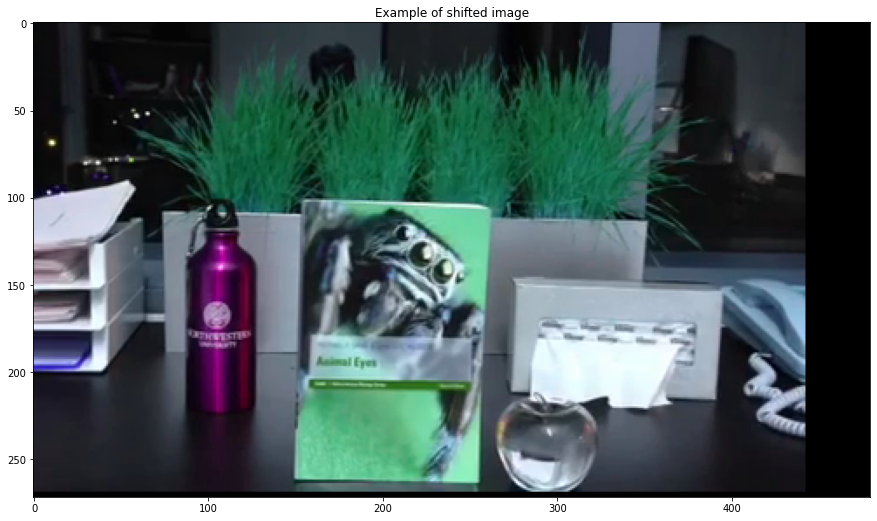

In [73]:
# Depending on you you've implemented the pixel_shift operations
# You might need to switch dx and dy. Here's the combination that worked for me
# Think about why I multiply with -1 !!! (you might need this too)

k = 10

dx = -1*pixel_shifts[1,k]
dy = -1*pixel_shifts[0,k]
img_translated = synthetic_aperture.translate_image(imgs[:,:,:,k],dx,dy)

print(img_translated.dtype)
plt.figure(figsize=(15,10))
plt.imshow(img_translated)
plt.title("Example of shifted image")

x0 = top_left_search_window[0]
x1 = x0 + window_size
y0 = top_left_search_window[1]
y1 = y0 + window_size

### <span style="color:orange">Sanity check: Has the image been registered correctly?</span>
Use this code to check if you registration approach has actually worked.

The following code should show on the left the original image, in the middle the original image that you want to register before shiftin and on the right the image after shifting.

The left and right image should now more or less overlap. If they are not registered, revisit your correlation or translation functions and try to identify the problem.

.//output_synthethic//proof_image_shift_and_registration_works.png


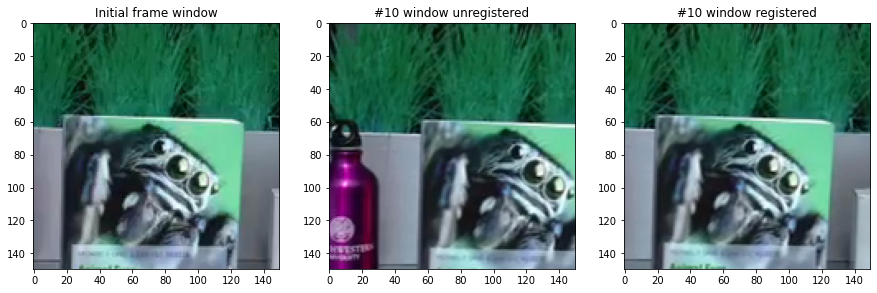

In [61]:
plt.figure(figsize=(15,15))
plt.subplot(131)
plt.imshow(imgs[x0:x1,y0:y1,:,0])
plt.title("Initial frame window")
plt.subplot(132)
plt.imshow(imgs[x0:x1,y0:y1,:,k])
plt.title("#" +str(k) + " window unregistered")
plt.subplot(133)
plt.imshow(img_translated[x0:x1,y0:y1,:])
plt.title("#" +str(k) + " window registered")

util_synthetic.save_fig_as_png("proof_image_shift_and_registration_works")

## <span style="color:orange">Task: Translate all images</span>

After you've successully implemented a function that can translate one image, you'll now have to implement a function that translates all images according to the calculated pixel_shifts.

You can use a for-loop for looping through the images and call the translate_image that you've implemented above

In [78]:
imgs_translated = synthetic_aperture.translate_all_images(imgs,pixel_shifts)

print(imgs.shape) # Those should have the same size now
print(imgs_translated.shape) # Those should now have the same size as imgs
print(imgs_translated.dtype) # Can be float or uint8. Doesn't really mattert

(272, 480, 3, 51)
(272, 480, 3, 51)
uint8


Now we will visualize how well the registration has worked. You can use the functions that we've already implemented for you to do this. This is simply to check that everything you've implemented is actually correct.

## <span style="color:orange">**Sanity check:** Did registration work for the complete dataset?</span>

.//output_synthethic//image_registration_after_shifting.png


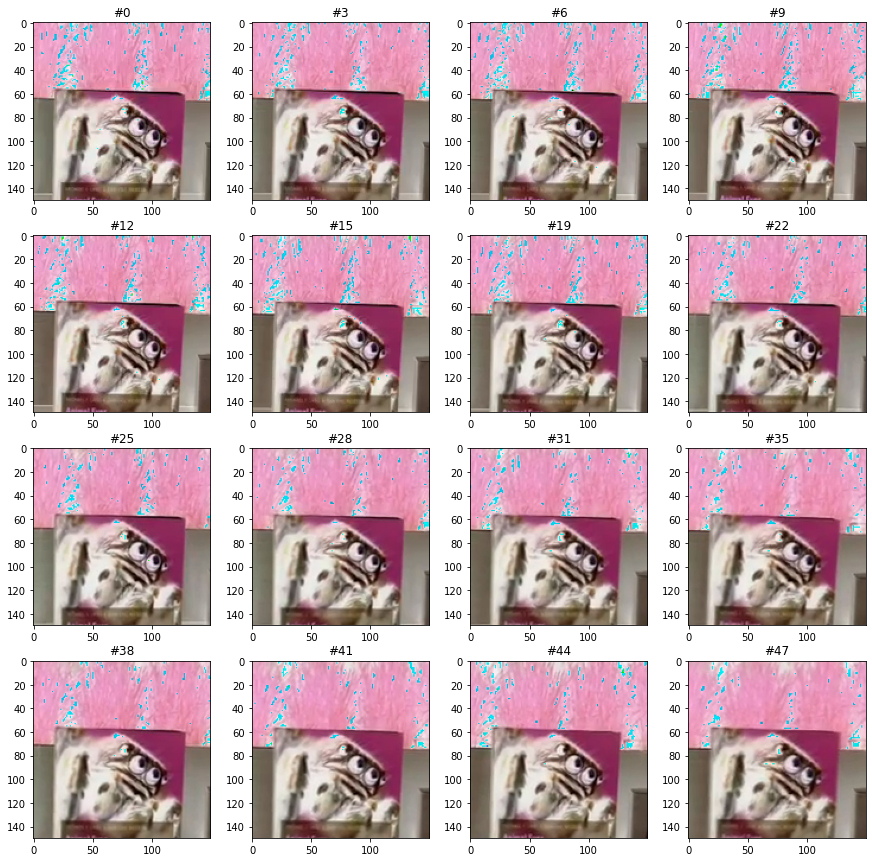

In [79]:
m_plots = 4
n_plots = 4

x0 = top_left_search_window[0]
x1 = x0 + window_size
y0 = top_left_search_window[1]
y1 = y0 + window_size

plt.figure(figsize=(15,15))
util_synthetic.visualizePixelShift(imgs_translated[x0:x1,y0:y1,:,:])

util_synthetic.save_fig_as_png("image_registration_after_shifting")

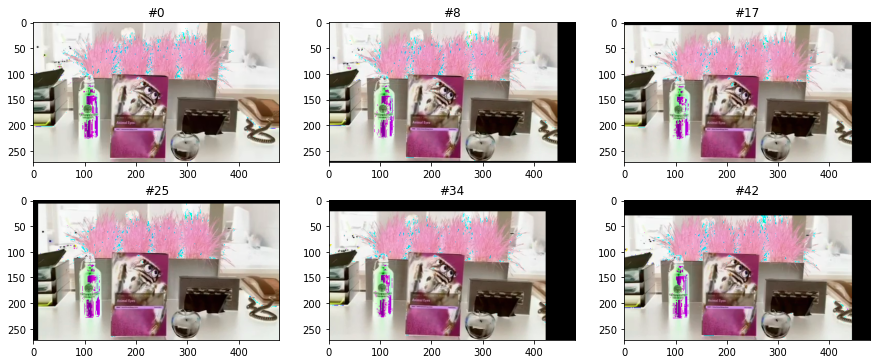

In [80]:
plt.figure(figsize=(15,6))
util_synthetic.visualizePixelShift(imgs_translated,2,3)

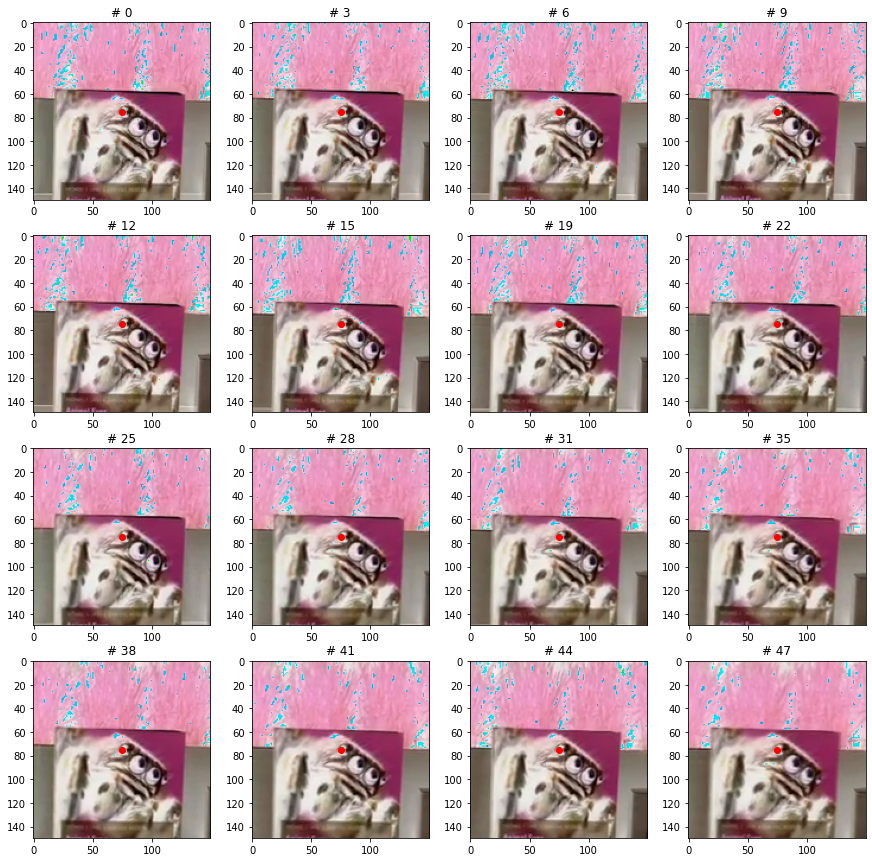

In [81]:
# This is to check that the feature that you registered against is actually in the center now !
plt.figure(figsize=(15,15))
util_synthetic.show_registered_images(imgs_translated,top_left_search_window,window_size)

### <span style="color:orange">Task: Average all images to get refocused</span>

After translation and registering the images all that is left to do is to average over all images. Then the final result should be the refocused image.

If this image looks weird or not as expected, try to identify where the problem is and solve it. You can write on campuswire and describe what you did, what worked and where you're think you got stock and we'll try to help you figuering it out.

(272, 480, 3)
uint8
.//output_synthethic//image_synthethic_one.png


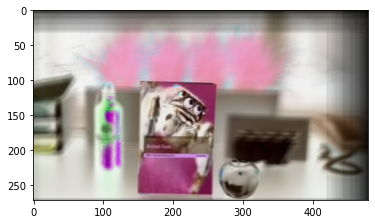

In [83]:
img_synthethic = synthetic_aperture.average_images(imgs_translated)
print(img_synthethic.shape)
print(img_synthethic.dtype)

plt.imshow(img_synthethic)

util_synthetic.save_fig_as_png("image_synthethic_one")

# <span style="color:orange">Problem: Build the synthethic aperture pipeline</span>

Now we have implemented the refocusing algorithm for only specific point. However, we'd like to have an algorithm that can focus on any point in the image. 

This is easy. All we have to do is choose a different center of focus. We then redefine the sesarch-window and the template of the first frame. Then we do exactly the same pipeline we have developped above and we're done.

In order to save some time for you, we have already implemented this function for you. You can check it out under "calculate_synthethic_aperture_image". Just by glancing over, you should be immediately see what steps we are performing and you should recognize everything that you've implemented in part 2.

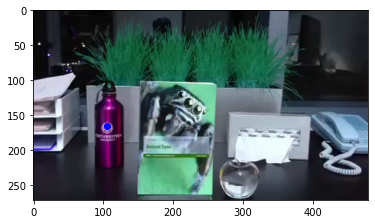

In [85]:
# Let's start by choosing a different point of focus. Here we're choosing the northwestern bottle as indicated as the blue point on the image.

focus_center=(165,105)
plt.imshow(imgs[:,:,:,0])
plt.scatter(focus_center[1],focus_center[0],color='b')



Now all that is left is to run the refocusing pipeline. Hopefully it works out of the box.

(272, 480, 3)
.//output_synthethic//image_synthethic_northwestern_bottle.png


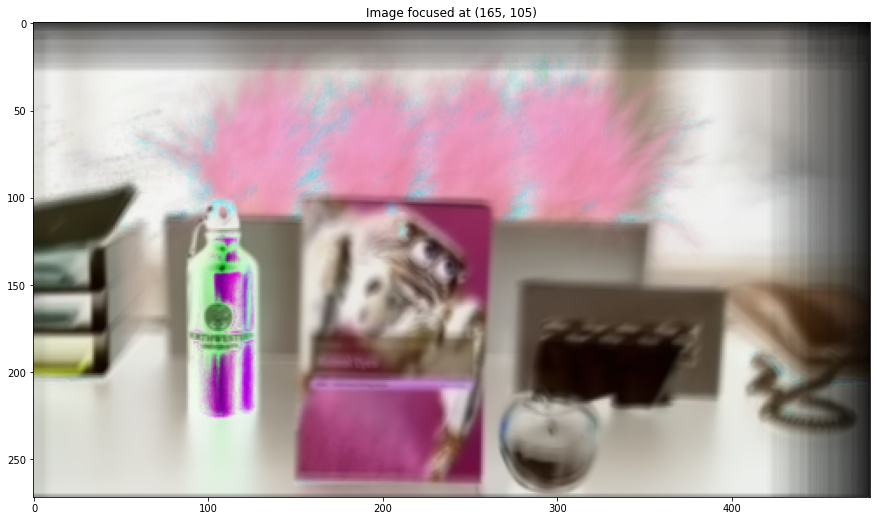

In [86]:
img_synthethic = util_synthetic.calculate_synthethic_aperture_image(imgs,focus_center)

print(img_synthethic.shape)

plt.figure(figsize=(15,10))
plt.imshow(img_synthethic)
plt.title("Image focused at " + str(focus_center))

util_synthetic.save_fig_as_png("image_synthethic_northwestern_bottle")

#### <span style="color:orange">Task: Play around with interactive refocusing widget</span>

Use the following cell which has some code for you that does interactive refocusing and play around with the algorithm. You can use this interactive viewer later for you own synthethic aperture video.

(76, 76)


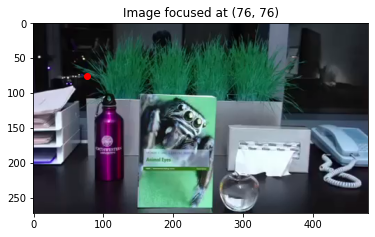

In [87]:
def f(x,y,refocus):
    
    plt.figure()
    plt.imshow(imgs[:,:,:,0])
    plt.scatter(y,x,color='r')
    
    focus_center = (x,y)
    
    print(focus_center)
    plt.title("Image focused at " + str(focus_center))

    plt.show()
    
    if refocus:
        plt.figure(figsize=(15,10))
        img_synthethic = util_synthetic.calculate_synthethic_aperture_image(imgs,focus_center,window_size,template_size)
        plt.imshow(img_synthethic)
        plt.title("Image focused at " + str(focus_center))

print(window_size)
print(template_size)

x_widget =  widgets.IntSlider(value = window_size/2,min=window_size/2+1, max=imgs.shape[0]-1-window_size/2, step=1)
y_widget =  widgets.IntSlider(value = window_size/2,min=window_size/2+1, max=imgs.shape[1]-1-window_size/2, step=1)
    
interactive_plot = interactive(f, x = x_widget, y = y_widget, refocus = False)
output = interactive_plot.children[-1]
output.layout.height = '15'
interactive_plot

# <span style="color:orange">Task: Implement the refocusing algorithm</span>
 
Now you will refocus on a new object. To do this you will simply select your template from the first from of video to be centered on a different object. Then all you need to do are repeat steps 3 and 4. 

# <span style="color:orange">Problem: Use your own video</span>

## <span style="color:orange">Task 1: Capture an unstructured light field with your camera</span>

NOTE: You don't have to do this now. You can do this AFTER you've implement your algorithm since we are providing you with an example movie which is ensured to work fine.

You can use any Android/iPhone camera application that records a video. You don't even have to use a smartphone. Any camera device will do the job. You will capture a video as you wave your camera around in front of a static scene.

Here are some guidelines that should help you capture a video:


1.    You need to avoid tilting and rotating the camera as much as possible. You should just shift the camera in a plane (see Figure 1). You may need to try this several times before you capture a good video.
2.    You should press the phone against a flat object (book, wall, etc.) to help guide the planar motion
3.    Experiment with different types of camera motion. You can try moving the camera in a zig-zag motion (as in Figure 1). You can also try using circular motion. In general, the more you cover the plane, the better your results in the next section will be.
4.    Make sure your video is not too long. You should capture a few seconds of video.
5.    Capture a scene with a few objects at different depths. See Figure 2 for an example. In the next section you will create narrow synthetic aperture images that are focused on these objects
6.    Make sure that all of the objects in the scene are in focus. As long as objects are about a meter in size and 1-2 meters away, they will more or less be in focus.

![test](pictures/camera-motion.png)

**Figure 1:** Capture an unstructured light field of a scene by waving a camera in front of a scene. Make sure the motion is in a plane.

## <span style="color:orange">Task 2: Load and synthesize your own large aperture image</span>

In [ ]:
imgs = util_synthetic.read_video_to_array(path)
imgs = imgs[:,:,:,::10] # only take every 10th frame
print(imgs.shape) # Should be (Num_x, Num_y, 3, Num_images)